In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras


In [14]:
#fds.list_builders()

In [68]:
ds = 'malaria'
builder = tfds.builder(ds)
info = builder.info
info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images
    with equal instances of parasitized and uninfected cells from the thin blood 
    smear slide images of segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='C:\\Users\\edmun\\tensorflow_datasets\\malaria\\1.0.0',
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward 
      improved malaria parasite detection in thin blood smear image

## Loading the data

In [105]:

ds_all, ds_all_info = tfds.load(name='malaria', split="train", shuffle_files=True, with_info=True)

train_ds, val_ds, test_ds = tfds.load(ds, split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'], shuffle_files=True)


In [70]:
print("Number of prediction classes:", ds_all_info.features['label'].num_classes)
print("Prediction classes:", ds_all_info.features['label'].names)

Number of prediction classes: 2
Prediction classes: ['parasitized', 'uninfected']


In [71]:
no_train = tf.data.experimental.cardinality(train_ds).numpy()
no_valid = tf.data.experimental.cardinality(val_ds).numpy()
no_test = tf.data.experimental.cardinality(test_ds).numpy()

In [72]:
print("Number of training images:", no_train)
print("Number of validating images:", no_valid)
print("Number of testing images:", no_test)

Number of training images: 19291
Number of validating images: 4133
Number of testing images: 4134


## Showing Examples

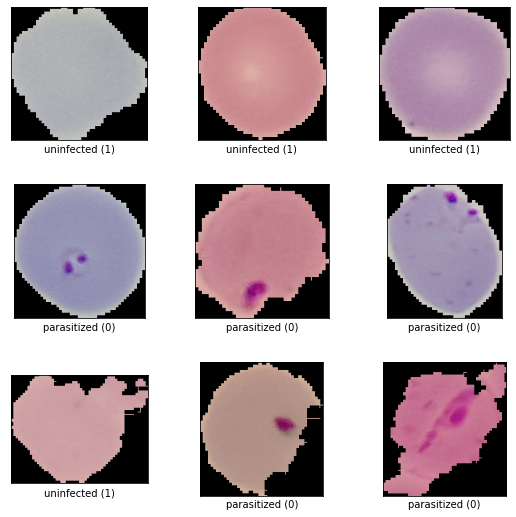

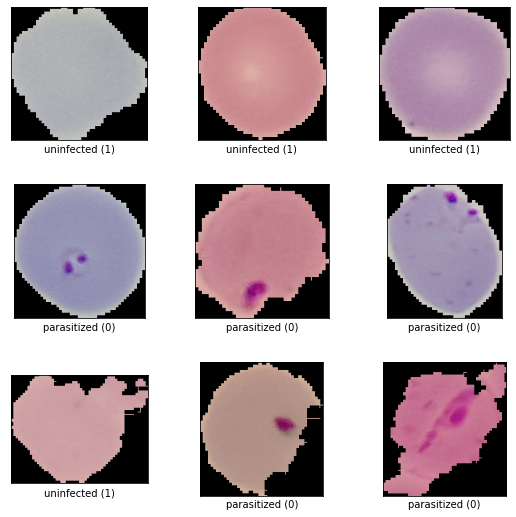

In [73]:
tfds.show_examples(ds_all, info)

## Model Building   

Extracting the images

In [131]:

train_images = np.array([example['image'].numpy() for example in train_ds], dtype="object")
train_labels = np.array([example['label'].numpy() for example in train_ds], dtype="object")

val_images = np.array([example['image'].numpy() for example in val_ds], dtype="object")
val_labels = np.array([example['label'].numpy() for example in val_ds], dtype="object")

test_images = np.array([example['image'].numpy() for example in test_ds], dtype="object")
test_labels = np.array([example['label'].numpy() for example in test_ds], dtype="object")

Checking to see the consistency in image lengths. 


In [132]:
for i in train_images[1:20]:
    print("Shape:",len(train_images[i][1]), "x", len(train_images[i]))

Shape: 118 x 118
Shape: 127 x 133
Shape: 139 x 151
Shape: 130 x 151
Shape: 148 x 145
Shape: 148 x 151
Shape: 175 x 139
Shape: 103 x 103
Shape: 157 x 115
Shape: 127 x 136
Shape: 139 x 166
Shape: 133 x 148
Shape: 106 x 112
Shape: 112 x 106
Shape: 130 x 124
Shape: 127 x 124
Shape: 136 x 142
Shape: 127 x 163
Shape: 115 x 109


The images are of different lengths. We need to pad/crop the images to achieve images of same lengths.

In [149]:
for i in range(len(train_images)):
    train_images[i] = tf.image.resize_with_crop_or_pad(train_images[i], 200, 200)
    train_images[i] = tf.image.convert_image_dtype(train_images[i], tf.float32)

In [148]:
for i in range(len(val_images)):
    val_images[i] = tf.image.resize_with_crop_or_pad(val_images[i], 200, 200)
    val_images[i] = tf.image.convert_image_dtype(val_images[i], tf.float32)

In [156]:
for i in range(len(test_images)):
    test_images[i] = tf.image.resize_with_crop_or_pad(test_images[i], 200, 200)
    test_images[i] = tf.image.convert_image_dtype(test_images[i], tf.float32)

In [158]:
test_images

array([<tf.Tensor: shape=(200, 200, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>,
       <tf.Tensor: shape=(